# CIFAR-10 compare

I intend to compare the results from the original paper with the ones I obtained on the dataset CIFAR-10.

Let's first check that I have all the runs. 

In [1]:
# setup

# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [2]:
%pwd

'/home/bertoldo/repos/fcdd/python/analyse'

In [5]:
%ls ../../data/results | grep cifar

cifar10/
fcdd_20211221161549_cifar10_/
fcdd_20211221161549_cifar10__AE/
fcdd_20211221161549_cifar10__HSC/


Because the experiments were cut due to issues in the machine, they are split in several folders, so I "merged" them by creating symbolic links.

In [9]:
%ls ../../data/results/cifar10/ | grep cifar
%ls ../../data/results/cifar10/fcdd_20211221161549_cifar10_/

fcdd_20211221161549_cifar10_@
fcdd_20211221161549_cifar10__AE@
fcdd_20211221161549_cifar10__HSC@
all_classwise_roc_curves/  normal_2/  normal_5/  normal_8/
normal_0/                  normal_3/  normal_6/  normal_9/
normal_1/                  normal_4/  normal_7/  roc.pdf


I will plot this as a reference but the roc curves are to be rebuilt.

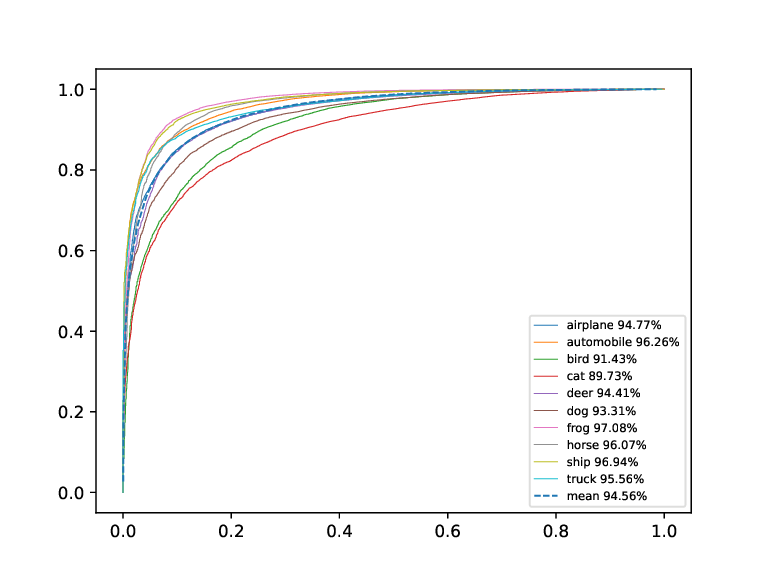

In [11]:
from wand.image import Image as WImage
pdf_path = '../../data/results/cifar10/fcdd_20211221161549_cifar10_/roc.pdf'
pdf_rocs = WImage(filename=pdf_path, resolution=120)
pdf_rocs

## funcs

In [13]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json


ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
ROC_JSON_LISTS = {"tpr", "fpr", "ths"}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    
    with path.open("r") as json_file:
        payload = json.load(json_file)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload

# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


def get_all_rocs_experiment(path: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    experiments = {
        (key := f"{dirpath.name}.{iterpath.name}"): {
            "key": key,
            "normal_class": dirpath.name,
            "it": iterpath.name,
            "dir": iterpath,
            "roc_json_path": (roc_json_path := iterpath / "roc.json"),
            "normal_class_label": get_class_label(dirpath.name, dataset),
            **get_roc(roc_json_path),
        }
        # first level: classes
        for dirpath in path.glob("normal_*")
        if dirpath.is_dir()
        # second level: iterations
        for iterpath in dirpath.glob("it_*")
        if iterpath.is_dir()
    }
    return experiments


## gather data

In [14]:
import pandas as pd

### load dataframe

In [15]:
experiment_path = Path("../../data/results/cifar10/fcdd_20211221161549_cifar10_/")
dataset = "cifar10"

records = get_all_rocs_experiment(experiment_path, dataset)

df = pd.DataFrame.from_records(data=records).T
df = df.drop(columns=["dir", "roc_json_path"])

In [17]:
df.head()

,key,normal_class,it,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,airplane,"[0.0, 0.00011111111111111112, 0.11222222222222...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.002,...","[51.81818389892578, 50.81818389892578, 16.0511...",0.948551
normal_0.it_1,normal_0.it_1,normal_0,it_1,airplane,"[0.0, 0.00011111111111111112, 0.14266666666666...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[60.85507583618164, 59.85507583618164, 14.4678...",0.945596
normal_0.it_2,normal_0.it_2,normal_0,it_2,airplane,"[0.0, 0.00011111111111111112, 0.20766666666666...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[62.59052276611328, 61.59052276611328, 12.3422...",0.947252
normal_0.it_3,normal_0.it_3,normal_0,it_3,airplane,"[0.0, 0.00011111111111111112, 0.22711111111111...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[53.17036819458008, 52.17036819458008, 11.7287...",0.949191
normal_0.it_4,normal_0.it_4,normal_0,it_4,airplane,"[0.0, 0.00011111111111111112, 0.14966666666666...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[51.99217224121094, 50.99217224121094, 14.3329...",0.948097


### basic checks

- number of classes
- number of iterations


In [19]:
df.describe()[["key", "normal_class", "normal_class_label", "it"]]

,key,normal_class,normal_class_label,it
count,50,50,50,50
unique,50,10,10,5
top,normal_0.it_0,normal_0,airplane,it_0
freq,1,5,5,10


In [20]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_2 normal_3 normal_4 normal_5 normal_6  \
it count            5        5        5        5        5        5        5   
   unique           5        5        5        5        5        5        5   
   top           it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq             1        1        1        1        1        1        1   

normal_class normal_7 normal_8 normal_9  
it count            5        5        5  
   unique           5        5        5  
   top           it_0     it_0     it_0  
   freq             1        1        1

### roc-auc

In [21]:
dataset = "cifar10"
labels_order = CLASS_LABELS[dataset]

rocauc_per_class = df.groupby("normal_class_label").agg({
    "auc": ["mean"],
})
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

# in percentage
rocauc_per_class = 100 * rocauc_per_class
rocauc_per_class["auc"] = rocauc_per_class["auc"].round(decimals=2)
rocauc_per_class = rocauc_per_class.loc[labels_order]
rocauc_per_class.loc["mean"] = rocauc_per_class.mean(axis=0)


In [22]:
cifar10_rocauc_per_class = rocauc_per_class
cifar10_rocauc_per_class

,auc
normal_class_label,
airplane,94.770
automobile,96.260
bird,91.430
cat,89.730
deer,94.410
dog,93.310
frog,97.080
horse,96.070
ship,96.940


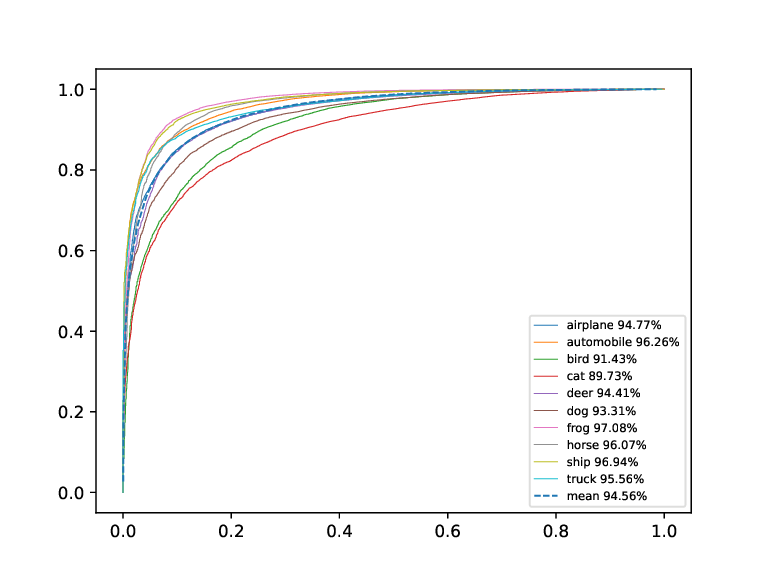

In [23]:
pdf_rocs

# CIFAR10 (baseline AE)

This is the baseline on cifar10 using AE

In [25]:
%ls ../../data/results/cifar10/ | grep cifar
%ls ../../data/results/cifar10/fcdd_20211221161549_cifar10__AE/

fcdd_20211221161549_cifar10_@
fcdd_20211221161549_cifar10__AE@
fcdd_20211221161549_cifar10__HSC@
normal_0/  normal_2/  normal_4/  normal_6/  normal_8/  roc.pdf
normal_1/  normal_3/  normal_5/  normal_7/  normal_9/


I will plot this as a reference but the roc curves are to be rebuilt.

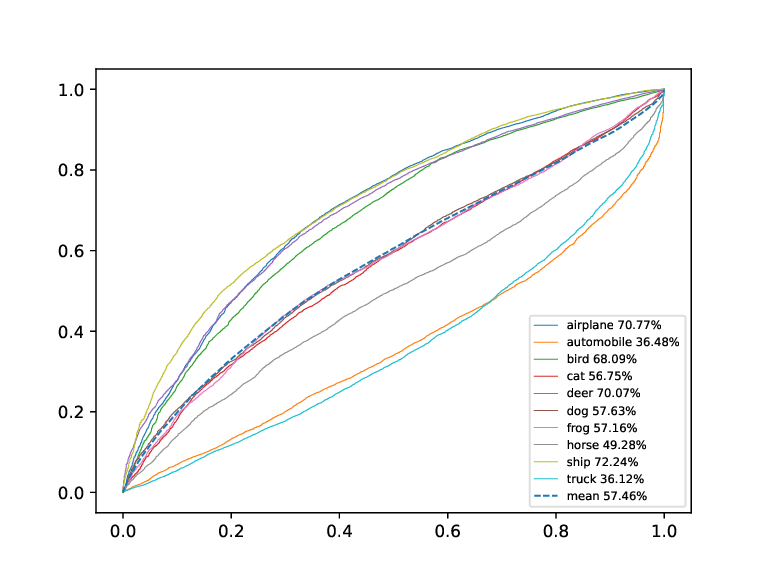

In [26]:
from wand.image import Image as WImage
pdf_path = '../../data/results/cifar10/fcdd_20211221161549_cifar10__AE/roc.pdf'
pdf_rocs = WImage(filename=pdf_path, resolution=120)
pdf_rocs

## gather data

In [14]:
import pandas as pd

### load dataframe

In [27]:
experiment_path = Path("../../data/results/cifar10/fcdd_20211221161549_cifar10__AE/")
dataset = "cifar10"

records = get_all_rocs_experiment(experiment_path, dataset)

df = pd.DataFrame.from_records(data=records).T
df = df.drop(columns=["dir", "roc_json_path"])

In [28]:
df.head()

,key,normal_class,it,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,airplane,"[0.0, 0.00011111111111111112, 0.00455555555555...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.5776860117912292, 0.5776860117912292, 0.398...",0.704045
normal_0.it_1,normal_0.it_1,normal_0,it_1,airplane,"[0.0, 0.00011111111111111112, 0.00222222222222...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.6189294457435608, 0.6189294457435608, 0.427...",0.705593
normal_0.it_2,normal_0.it_2,normal_0,it_2,airplane,"[0.0, 0.00011111111111111112, 0.001, 0.001, 0....","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.5942881107330322, 0.5942881107330322, 0.481...",0.712289
normal_0.it_3,normal_0.it_3,normal_0,it_3,airplane,"[0.0, 0.00011111111111111112, 0.00588888888888...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.6536983847618103, 0.6536983847618103, 0.412...",0.711974
normal_0.it_4,normal_0.it_4,normal_0,it_4,airplane,"[0.0, 0.00011111111111111112, 0.00222222222222...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.6618639826774597, 0.6618639826774597, 0.426...",0.704499


### basic checks

- number of classes
- number of iterations


In [29]:
df.describe()[["key", "normal_class", "normal_class_label", "it"]]

,key,normal_class,normal_class_label,it
count,50,50,50,50
unique,50,10,10,5
top,normal_0.it_0,normal_0,airplane,it_0
freq,1,5,5,10


In [30]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_2 normal_3 normal_4 normal_5 normal_6  \
it count            5        5        5        5        5        5        5   
   unique           5        5        5        5        5        5        5   
   top           it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq             1        1        1        1        1        1        1   

normal_class normal_7 normal_8 normal_9  
it count            5        5        5  
   unique           5        5        5  
   top           it_0     it_0     it_0  
   freq             1        1        1

### roc-auc

In [31]:
dataset = "cifar10"
labels_order = CLASS_LABELS[dataset]

rocauc_per_class = df.groupby("normal_class_label").agg({
    "auc": ["mean"],
})
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

# in percentage
rocauc_per_class = 100 * rocauc_per_class
rocauc_per_class["auc"] = rocauc_per_class["auc"].round(decimals=2)
rocauc_per_class = rocauc_per_class.loc[labels_order]
rocauc_per_class.loc["mean"] = rocauc_per_class.mean(axis=0)


In [32]:
cifar10_ae_rocauc_per_class = rocauc_per_class
cifar10_ae_rocauc_per_class

,auc
normal_class_label,
airplane,70.770
automobile,36.480
bird,68.090
cat,56.750
deer,70.070
dog,57.630
frog,57.160
horse,49.280
ship,72.240


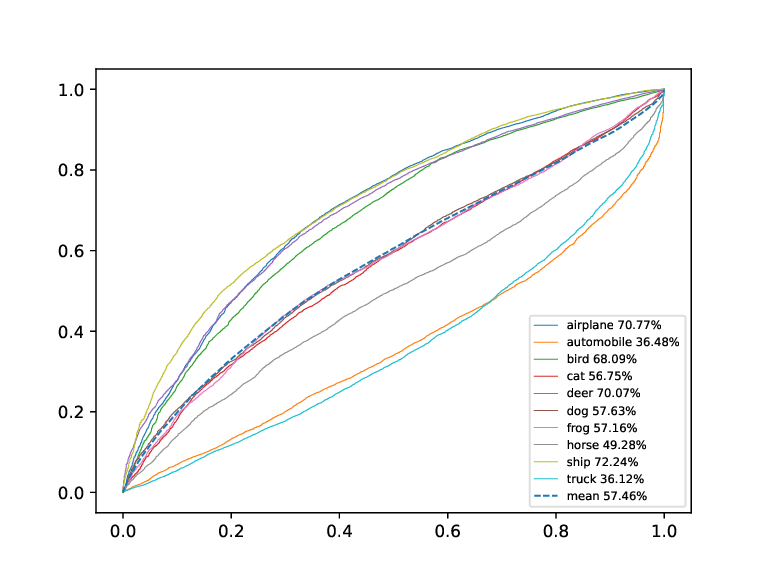

In [33]:
pdf_rocs

# compare

## paper data

from Table 7, page 18

this corresponds to `cifar10_rocauc_per_class`, column "fcdd"

the `cifar10_ae_rocauc_per_class` "should" correspond to the column "ae" but the paper uses the results from elsewhere


In [40]:
str_data = """
Airplane
 0.59
 0.62
 0.75
 0.78
 0.88
 0.90
 0.94
 0.97
 0.95
Automobile
 0.57
 0.66
 0.96
 0.97
 0.94
 0.99
 0.98
 0.99
 0.96
Bird
 0.49
 0.51
 0.78
 0.87
 0.79
 0.94
 0.90
 0.93
 0.91
Cat
 0.58
 0.59
 0.72
 0.81
 0.80
 0.88
 0.87
 0.90
 0.90
Deer
 0.54
 0.61
 0.88
 0.93
 0.82
 0.97
 0.95
 0.97
 0.94
Dog
 0.62
 0.66
 0.88
 0.90
 0.86
 0.94
 0.93
 0.94
 0.93
Frog
 0.51
 0.68
 0.83
 0.91
 0.93
 0.97
 0.97
 0.98
 0.97
Horse
 0.59
 0.67
 0.96
 0.97
 0.88
 0.99
 0.97
 0.98
 0.96
Ship
 0.77
 0.76
 0.93
 0.95
 0.93
 0.99
 0.97
 0.98
 0.97
Truck
 0.67
 0.73
 0.91
 0.93
 0.92
 0.99
 0.96
 0.97
 0.96
Mean
 0.59
 0.65
 0.86
 0.90
 0.87
 0.96
 0.95
 0.96
 0.95
"""

nlines_per_group = 10
lines = str_data.strip().split("\n")
line_groups = [
    lines[(i * nlines_per_group):((i + 1) * nlines_per_group)] 
    for i in range(len(lines) // nlines_per_group)
]
line_groups = [
    {
        "normal_class_label": g[0].lower(),
        "ae": 100 * float(g[1]),
        "fcdd": 100 * float(g[-1]),
    }
    for g in line_groups
]
paper_df = pd.DataFrame.from_records(data=line_groups).set_index("normal_class_label")
paper_df

,ae,fcdd
normal_class_label,,
airplane,59.0,95.0
automobile,57.0,96.0
bird,49.0,91.0
cat,58.0,90.0
deer,54.0,94.0
dog,62.0,93.0
frog,51.0,97.0
horse,59.0,96.0
ship,77.0,97.0


## my data

In [41]:
# are the rows (classes) in the same order?
cifar10_rocauc_per_class.index == cifar10_ae_rocauc_per_class.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [42]:
cifar10_rocauc_per_class
cifar10_ae_rocauc_per_class

,auc
normal_class_label,
airplane,94.770
automobile,96.260
bird,91.430
cat,89.730
deer,94.410
dog,93.310
frog,97.080
horse,96.070
ship,96.940


,auc
normal_class_label,
airplane,70.770
automobile,36.480
bird,68.090
cat,56.750
deer,70.070
dog,57.630
frog,57.160
horse,49.280
ship,72.240


In [43]:
my_df = pd.concat([
    cifar10_ae_rocauc_per_class.rename(columns={"auc": "ae"}),
    cifar10_rocauc_per_class.rename(columns={"auc": "fcdd"}),
], axis=1)
my_df

,ae,fcdd
normal_class_label,,
airplane,70.770,94.770
automobile,36.480,96.260
bird,68.090,91.430
cat,56.750,89.730
deer,70.070,94.410
dog,57.630,93.310
frog,57.160,97.080
horse,49.280,96.070
ship,72.240,96.940


## compare df

In [44]:
diff_df = my_df - paper_df
compare_df = pd.concat(
    [my_df, paper_df, diff_df, diff_df.abs()], 
    axis=1, 
    keys=("ours", "original", "diff", "absdiff")
)
compare_df

ours         original          diff        absdiff  \
                        ae    fcdd       ae  fcdd      ae   fcdd      ae   
normal_class_label                                                         
airplane            70.770  94.770     59.0  95.0  11.770 -0.230  11.770   
automobile          36.480  96.260     57.0  96.0 -20.520  0.260  20.520   
bird                68.090  91.430     49.0  91.0  19.090  0.430  19.090   
cat                 56.750  89.730     58.0  90.0  -1.250 -0.270   1.250   
deer                70.070  94.410     54.0  94.0  16.070  0.410  16.070   
dog                 57.630  93.310     62.0  93.0  -4.370  0.310   4.370   
frog                57.160  97.080     51.0  97.0   6.160  0.080   6.160   
horse               49.280  96.070     59.0  96.0  -9.720  0.070   9.720   
ship                72.240  96.940     77.0  97.0  -4.760 -0.060   4.760   
truck               36.120  95.560     67.0  96.0 -30.880 -0.440  30.880   
mean                57.459  94.556     59.0  95.0  -1.541 -0.444   1.541   

                           
                     fcdd  
normal_class_label         
airplane            0.230  
automobile          0.260  
bird                0.430  
cat                 0.270  
deer                0.410  
dog                 0.310  
frog                0.080  
horse               0.070  
ship                0.060  
truck               0.440  
mean                0.444

In [45]:
compare_df.drop(index="mean").describe()

ours              original                  diff            \
              ae       fcdd         ae       fcdd         ae      fcdd   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.00000   
mean   57.459000  94.556000  59.300000  94.500000  -1.841000   0.05600   
std    13.460662   2.425321   8.097325   2.460804  15.908415   0.30178   
min    36.120000  89.730000  49.000000  90.000000 -30.880000  -0.44000   
25%    51.147500  93.585000  54.750000  93.250000  -8.480000  -0.18750   
50%    57.395000  95.165000  58.500000  95.500000  -2.810000   0.07500   
75%    69.575000  96.212500  61.250000  96.000000  10.367500   0.29750   
max    72.240000  97.080000  77.000000  97.000000  19.090000   0.43000   

         absdiff             
              ae       fcdd  
count  10.000000  10.000000  
mean   12.459000   0.256000  
std     9.185283   0.147437  
min     1.250000   0.060000  
25%     5.110000   0.117500  
50%    10.745000   0.265000  
75%    18.335000   0.385000  
max    30.880000   0.440000